In [1]:
import ccxt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
creds = json.loads(open('../creds.json', 'r').read())

In [3]:
exchange = ccxt.binance(creds['binance'])
# exchange = ccxt.phemex(creds['phemex'])

In [4]:
exchange.rateLimit

500

In [5]:
exchange.enableRateLimit = True

## We fetch the last BTC tickers from Binance

In [6]:
from datetime import timezone 
import datetime
dt = datetime.datetime.now()   
utc_time = dt.replace(tzinfo = timezone.utc) 
utc_timestamp = utc_time.timestamp() 
  
timestamp = utc_timestamp
# timestamp *= 1000

In [7]:
timestamp

1615291791.67275

In [8]:
candles = np.array(exchange.fetch_ohlcv("BTC/USDT", '5m'))
n = candles.shape[0]

In [9]:
candles

array([[1.61513820e+12, 5.09956200e+04, 5.09956200e+04, 5.09187800e+04,
        5.09480100e+04, 1.25181259e+02],
       [1.61513850e+12, 5.09474700e+04, 5.10400000e+04, 5.09414400e+04,
        5.09414400e+04, 1.14658232e+02],
       [1.61513880e+12, 5.09414400e+04, 5.10000000e+04, 5.09320200e+04,
        5.09645100e+04, 7.56538470e+01],
       ...,
       [1.61528730e+12, 5.42099100e+04, 5.42164800e+04, 5.41060200e+04,
        5.41595200e+04, 1.96321818e+02],
       [1.61528760e+12, 5.41595200e+04, 5.42399700e+04, 5.40310000e+04,
        5.42372000e+04, 2.22448064e+02],
       [1.61528790e+12, 5.42371900e+04, 5.42939700e+04, 5.41326900e+04,
        5.42558400e+04, 2.25099440e+02]])

In [430]:
for _ in range(4):
    candles2 = np.array(exchange.fetch_ohlcv("BTC/USDT", '1h', int(candles[0, 0] - n * 60 * 60 * 1000)))
    candles = np.vstack([candles2, candles])

In [10]:
data = pd.DataFrame()
data['timestamp'] = candles[:, 0]
data['date'] = pd.to_datetime(data['timestamp'] * 1000000)
data['open'] = candles[:, 1]
data['high'] = candles[:, 2]
data['low'] = candles[:, 3]
data['close'] = candles[:, 4]
data['volume'] = candles[:, 5]

## MACD calculation

In [11]:
ewm12 = data['close'].ewm(span=12, adjust=False).mean()
ewm26 = data['close'].ewm(span=26, adjust=False).mean()
macd = ewm12 - ewm26
macd9 = macd.ewm(span=9, adjust=False).mean()
data['macd'] = macd
data['macd9'] = macd9

In [12]:
data

,timestamp,date,open,high,low,close,volume,macd,macd9
0,1.615138e+12,2021-03-07 17:30:00,50995.62,50995.62,50918.78,50948.01,125.181259,0.000000,0.000000
1,1.615138e+12,2021-03-07 17:35:00,50947.47,51040.00,50941.44,50941.44,114.658232,-0.524103,-0.104821
2,1.615139e+12,2021-03-07 17:40:00,50941.44,51000.00,50932.02,50964.51,75.653847,0.911590,0.098462
3,1.615139e+12,2021-03-07 17:45:00,50964.50,50964.51,50866.84,50877.81,145.789774,-4.890207,-0.899272
4,1.615139e+12,2021-03-07 17:50:00,50877.82,50920.00,50757.59,50896.57,207.047195,-7.883521,-2.296122
...,...,...,...,...,...,...,...,...,...
495,1.615287e+12,2021-03-09 10:45:00,54036.01,54093.55,53990.00,54078.15,221.725263,28.804653,52.654316
496,1.615287e+12,2021-03-09 10:50:00,54078.15,54216.48,54041.95,54209.91,188.474545,35.165006,49.156454
497,1.615287e+12,2021-03-09 10:55:00,54209.91,54216.48,54106.02,54159.52,196.321818,35.727733,46.470710
498,1.615288e+12,2021-03-09 11:00:00,54159.52,54239.97,54031.00,54237.20,222.448064,41.958158,45.568200


## MACD crossovers calculations

In [13]:
macd9_shifted = data['macd9'].shift(1)
macd_shifted = data['macd'].shift(1)

crossovers_buy = (macd_shifted < macd9_shifted) & (data['macd'] >= data['macd9'])
data['crossover_buy'] = crossovers_buy

crossovers_sell = (macd_shifted > macd9_shifted) & (data['macd'] <= data['macd9'])
data['crossover_sell'] = crossovers_sell

## Plotting everything

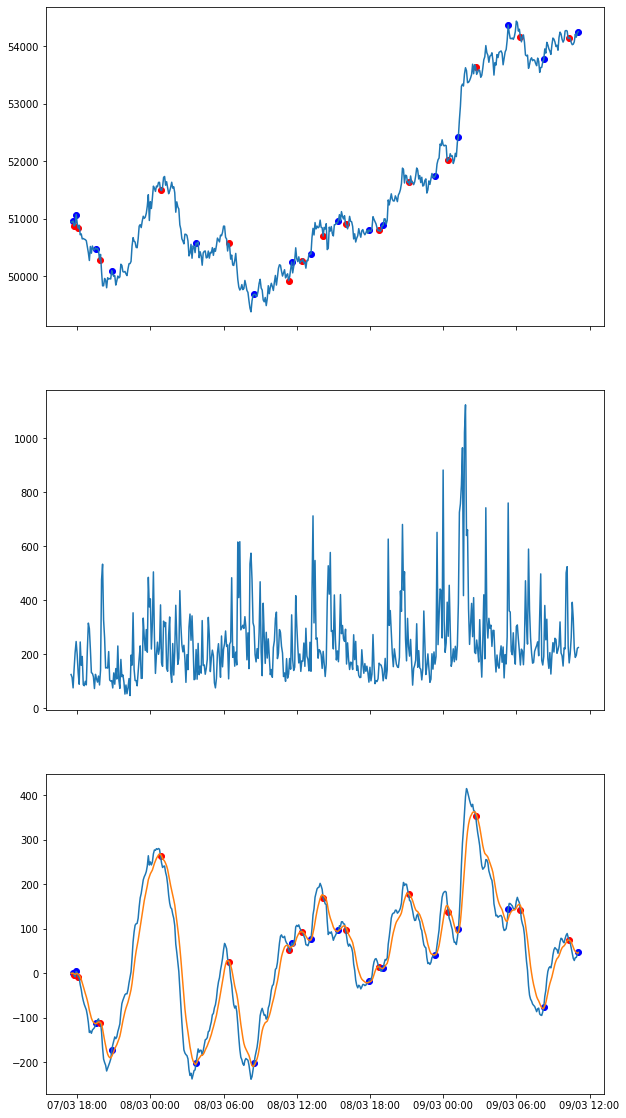

In [14]:
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 20))
ax1.plot(data['date'], data['close'])
ax2.plot(data['date'], data['volume'])
ax3.plot(data['date'], data['macd'])
ax3.plot(data['date'], data['macd9'])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))

for index, row in data.iterrows():
    if (row['crossover_buy']):
        ax3.scatter(row['date'], row['macd'], color='b')
        ax1.scatter(row['date'], row['close'], color='b')
    if (row['crossover_sell']):
        ax3.scatter(row['date'], row['macd'], color='r')
        ax1.scatter(row['date'], row['close'], color='r')

plt.show()

## Calculating estimated profit

In [21]:
profits = []
taker_fee = 0.1

last_buy = None
for index, row in data.iterrows():
    if (row['crossover_buy'] and not last_buy):
        last_buy = (row['open'] + row['close']) / 2
        print("Buy @{:.2f}".format(last_buy))
    if (row['crossover_sell'] and last_buy):
        price = (row['open'] + row['close']) / 2
        variation = (price - last_buy) / last_buy * 100
        profits.append(variation - taker_fee)
        last_buy = None
        print("Sell @{:.2f}, profit {:.2f}".format(price, profits[-1]))
print("Total: {:.2f}".format(np.array(profits).sum()))

Buy @50952.98
Sell @50921.15, profit -0.16
Buy @50986.63
Sell @50883.18, profit -0.30
Buy @50486.18
Sell @50370.55, profit -0.33
Buy @50027.06
Sell @51569.85, profit 2.98
Buy @50496.10
Sell @50507.47, profit -0.08
Buy @49680.72
Sell @49985.88, profit 0.51
Buy @50188.58
Sell @50264.62, profit 0.05
Buy @50388.40
Sell @50771.65, profit 0.66
Buy @50948.18
Sell @50984.00, profit -0.03
Buy @50779.76
Sell @50798.64, profit -0.06
Buy @50885.97
Sell @51640.92, profit 1.38
Buy @51725.94
Sell @52016.28, profit 0.46
Buy @52380.56
Sell @53655.78, profit 2.33
Buy @54238.41
Sell @54228.76, profit -0.12
Buy @53750.71
Sell @54140.78, profit 0.63
Buy @54246.51
Total: 7.93


In [16]:
len(profits) / (data.shape[0] / 60)

1.7999999999999998

In [17]:
np.array(profits).mean()

0.5288795772550043

# Fetch balance

In [18]:
balance = exchange.fetch_balance()

In [20]:
balance['USDT']['total']

100.0

In [445]:
exchange.fetch_open_orders("BTC/USDT")

InvalidNonce: binance {"code":-1021,"msg":"Timestamp for this request is outside of the recvWindow."}

# Tweeting

In [411]:
import tweepy

In [413]:
auth = tweepy.OAuthHandler(creds['twitter']['apiKey'], 
    creds['twitter']['secret'])
auth.set_access_token(creds['twitter']['accessToken'], 
    creds['twitter']['accessTokenSecret'])

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [414]:
api.update_status("Hello! This tweet is sent from a #Python notebook :)")

Status(_api=<tweepy.api.API object at 0x1187a88b0>, _json={'created_at': 'Mon Mar 08 22:03:27 +0000 2021', 'id': 1369046127404810244, 'id_str': '1369046127404810244', 'text': 'Hello! This tweet is sent from a #Python notebook :)', 'truncated': False, 'entities': {'hashtags': [{'text': 'Python', 'indices': [33, 40]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1369041402995281922, 'id_str': '1369041402995281922', 'name': 'MACD crypto bot', 'screen_name': 'bot_macd', 'location': '', 'description': "I'm a bot.\nI buy every MACD crossover on $BTC.\nI tweet my trades and current balance.\nMy father is @AirM4rx.\n#btc", 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 1, 'listed_count': 0, 'created_at': 'Mon Mar 08 21:44:56 +0000 2021

Tweet with matplotlib visualization

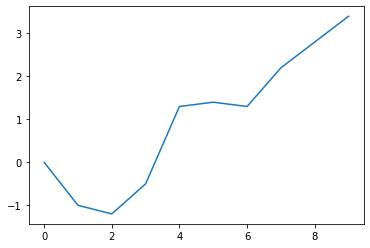

In [420]:
# Random matplotlib graph
x = list(range(10))
y = [0, -1, -1.2, -0.5, 1.3, 1.4, 1.3, 2.2, 2.8, 3.4]

plt.plot(x, y)
plt.savefig("/tmp/vis.png")

In [421]:
media = api.media_upload("/tmp/vis.png")
tweet = "Testing to tweet a #matplotlib graph!!!"
post_result = api.update_status(status=tweet, media_ids=[media.media_id])